In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn
import sys

from tqdm import tqdm
from Reservoir import CustomReservoir

%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:2" if use_cuda else "cpu")

dpi = 100
figsize = (8,8)

In [18]:
def stability_test(res_size=100, input_size=100, input_len=100, resolution=20, res_scale_bounds=[0, 3], input_scale_bounds=[0, 2]):
    input_data = torch.randn(input_len, input_size).to(device)
    for i in range(input_len):  # normalize input at each timestep
        input_data[i, :] = input_data[i, :] / torch.norm(input_data[i, :])

    res_scale_list = np.linspace(res_scale_bounds[0], res_scale_bounds[1], num=resolution)
    input_scale_list = np.linspace(input_scale_bounds[0], input_scale_bounds[1], num=resolution)
    final_metric = torch.zeros(resolution, resolution)
    W_in = torch.randn(res_size, input_size).to(device)
    W_res = torch.randn(res_size, res_size).to(device)
    initial_state1 = torch.randn(res_size).to(device) / np.sqrt(res_size)
    initial_state1 = initial_state1 / torch.norm(initial_state1)
    initial_state2 = torch.randn(res_size).to(device) / np.sqrt(res_size)
    initial_state2 = initial_state2 / torch.norm(initial_state2)
    for (i_in, input_scale) in tqdm(enumerate(input_scale_list)):
        RC = CustomReservoir(f="erf", input_size=input_size, res_size=res_size,
                        W_res=W_res, W_in=W_in,
                        input_scale=input_scale)
        rc_metric = RC.stability_test(input_data, res_scale_list, initial_state1=initial_state1, initial_state2=initial_state2)
        final_metric[:, i_in] = torch.mean(rc_metric[:, -10:], dim=1)
    return final_metric

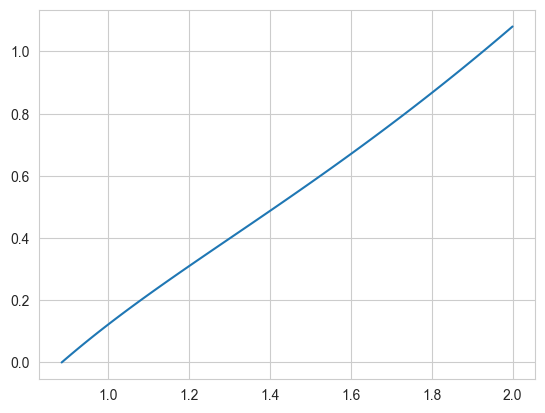

In [52]:
from utils import erf_frontier

min_sigma_r = np.sqrt(np.pi) / 2
max_sigma_r = 2
n_points = 100
sigma_r_l = np.linspace(min_sigma_r, max_sigma_r, n_points)
sigma_i = erf_frontier(sigma_r_l)

plt.plot(sigma_r_l, sigma_i)
plt.show()

In [62]:
res_size = 101
input_size = 102
input_len = 1000
resolution = 500
res_scale_bounds = [1.74, 1.76]
input_scale_bounds = [1.11, 1.14]
metric_erf = stability_test(res_size=res_size, input_size=input_size, input_len=input_len, resolution=resolution, res_scale_bounds=res_scale_bounds, input_scale_bounds=input_scale_bounds)
img = metric_erf.T

500it [04:23,  1.90it/s]


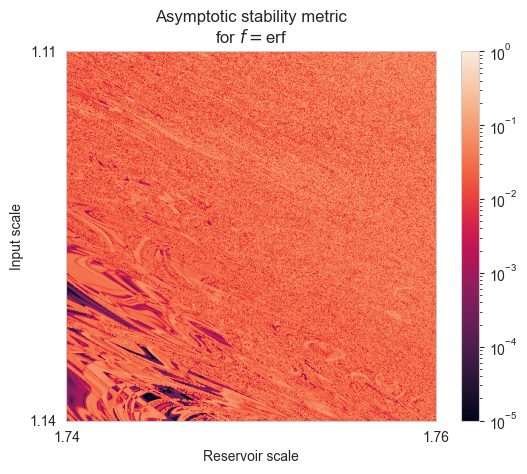

In [63]:
plt.figure()
seaborn.set_style("whitegrid")

threshold = 1e-5
img[img<threshold]= threshold
input_min = 0
input_max = 1
res_min = 0
res_max = 1
plt.imshow(img[int(input_min*resolution):int(input_max*resolution), int(res_min*resolution):int(res_max*resolution)], norm=matplotlib.colors.LogNorm(vmin= 1e-10, vmax = 1))#


ax = plt.gca()
plt.grid(False)
plt.clim(threshold, 1)
plt.colorbar()

input_scale_min = input_scale_bounds[0] + input_min * (input_scale_bounds[1] - input_scale_bounds[0])
input_scale_max = input_scale_bounds[0] + input_max * (input_scale_bounds[1] - input_scale_bounds[0])
res_scale_min = res_scale_bounds[0] + res_min * (res_scale_bounds[1] - res_scale_bounds[0])
res_scale_max = res_scale_bounds[0] + res_max * (res_scale_bounds[1] - res_scale_bounds[0])
ylab = np.linspace(input_scale_min, input_scale_max, num=int(input_scale_bounds[1]+1))
xlab = np.linspace(res_scale_min, res_scale_max, num=int(res_scale_bounds[1]+1))
indXx = np.linspace(0, resolution-1, num=xlab.shape[0]).astype(int)
indXy = np.linspace(0, resolution-1, num=ylab.shape[0]).astype(int)

# color = "skyblue"
# plt.contour(metric_erf.T, levels=[threshold*10], colors=color, linewidths=[1])
# # plt.annotate('frontier', xy=(70, 80), color=color)
# plt.annotate('frontier', xy=(21, 40), color=color, fontsize=12)

ax.set_xticks(indXx)
ax.set_xticklabels(xlab)
ax.set_yticks(indXy)
ax.set_yticklabels(ylab)
ax.set_xlabel('Reservoir scale')
ax.set_ylabel('Input scale')
ax.set_title('Asymptotic stability metric\nfor $f=$erf')

plt.savefig("fig/241128small_region2.png")
plt.show()


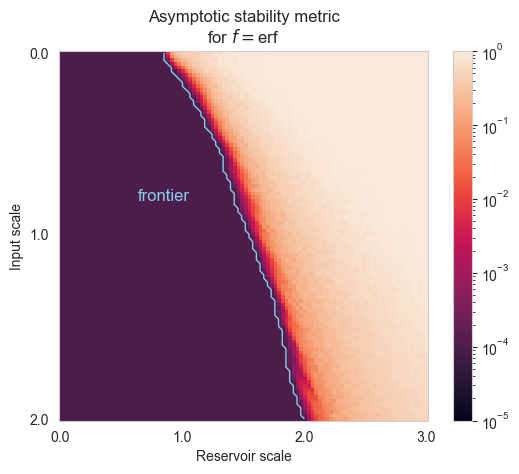

In [ ]:
plt.figure()
seaborn.set_style("whitegrid")
img = metric_erf.T
threshold = 1e-5
img[img<threshold]= threshold
plt.imshow(img, norm=matplotlib.colors.LogNorm(vmin= 1e-10, vmax = 1))#

ax = plt.gca()
plt.grid(False)
plt.clim(threshold, 1)
plt.colorbar()

ylab = np.linspace(input_scale_bounds[0], input_scale_bounds[1], num=int(input_scale_bounds[1]+1))
xlab = np.linspace(res_scale_bounds[0], res_scale_bounds[1], num=int(res_scale_bounds[1]+1))
indXx = np.linspace(0, resolution-1, num=xlab.shape[0]).astype(int)
indXy = np.linspace(0, resolution-1, num=ylab.shape[0]).astype(int)

color = "skyblue"
plt.contour(metric_erf.T, levels=[threshold*10], colors=color, linewidths=[1])
# plt.annotate('frontier', xy=(70, 80), color=color)
plt.annotate('frontier', xy=(21, 40), color=color, fontsize=12)

ax.set_xticks(indXx)
ax.set_xticklabels(xlab)
ax.set_yticks(indXy)
ax.set_yticklabels(ylab)
ax.set_xlabel('Reservoir scale')
ax.set_ylabel('Input scale')
ax.set_title('Asymptotic stability metric\nfor $f=$erf')

# plt.savefig("220125relu.svg")
plt.show()


In [ ]:
cids = []
click_event = [None]

def onclick(event):
  click_event[0] = (event.xdata, event.ydata)


def onrelease(event, fig, im, rect, mnmx, img, recalculate_image=True):
  if click_event[0] is None:
    return

  e0 = [click_event[0][0], event.xdata]
  e1 = [click_event[0][1], event.ydata]

  for v in e0+e1:
    if v is None:
      return

  newmnmx = [np.min(e1), np.max(e1), np.min(e0), np.max(e0)]

  min_w = (mnmx[1] - mnmx[0])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[1] + newmnmx[0])/2.
    newmnmx[0] = c - min_w/2
    newmnmx[1] = c + min_w/2
  min_w = (mnmx[3] - mnmx[2])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[3] + newmnmx[2])/2.
    newmnmx[2] = c - min_w/2
    newmnmx[3] = c + min_w/2

  for v in newmnmx:
    if v is None:
      return
  plot_img(img, mnmx, newmnmx, fig=fig, im=im, rect=rect)#will be modified
  plt.draw()

  if recalculate_image:
    click_event[0] = None
    mnmx = newmnmx
    img = stability_test(res_size=res_size, input_size=input_size, input_len=input_len, resolution=resolution, 
                         res_scale_bounds=mnmx[:2], input_scale_bounds=mnmx[2:])
    plot_img(img, mnmx, None, fig=fig, im=im, rect=rect)#will be modified



def plot_img(img, mnmx, newmnmx=None, fig=None, im=None, rect=None,
             handler=True, savename=None
             ):
  mn1, mx1, mn2, mx2 = mnmx
  input_scale_bounds = mnmx[2:]
  res_scale_bounds = mnmx[:2]

  ax1 = None
  if fig is None:
    fig, (ax1) = plt.subplots(figsize=figsize, dpi=dpi)
    seaborn.set_style("whitegrid")
    threshold = 1e-5
    img[img<threshold]= threshold
    # input_min = 0
    # input_max = 1
    # res_min = 0
    # res_max = 1
    im = ax1.imshow(img, norm=matplotlib.colors.LogNorm(vmin= 1e-10, vmax = 1))#[int(input_min*resolution):int(input_max*resolution), int(res_min*resolution):int(res_max*resolution)]


  ax = plt.gca()
  plt.grid(False)
  plt.clim(threshold, 1)
  plt.colorbar()

  input_scale_min = input_scale_bounds[0]# + input_min * (input_scale_bounds[1] - input_scale_bounds[0])
  input_scale_max = input_scale_bounds[0]# + input_max * (input_scale_bounds[1] - input_scale_bounds[0])
  res_scale_min = res_scale_bounds[0]# + res_min * (res_scale_bounds[1] - res_scale_bounds[0])
  res_scale_max = res_scale_bounds[0]# + res_max * (res_scale_bounds[1] - res_scale_bounds[0])
  ylab = np.linspace(input_scale_min, input_scale_max, num=int(input_scale_bounds[1]+1))
  xlab = np.linspace(res_scale_min, res_scale_max, num=int(res_scale_bounds[1]+1))
  indXx = np.linspace(0, resolution-1, num=xlab.shape[0]).astype(int)
  indXy = np.linspace(0, resolution-1, num=ylab.shape[0]).astype(int)

    # color = "skyblue"
    # plt.contour(metric_erf.T, levels=[threshold*10], colors=color, linewidths=[1])
    # # plt.annotate('frontier', xy=(70, 80), color=color)
    # plt.annotate('frontier', xy=(21, 40), color=color, fontsize=12)

  ax1.set_xticks(indXx)
  ax1.set_xticklabels(xlab)
  ax1.set_yticks(indXy)
  ax1.set_yticklabels(ylab)
  ax1.set_xlabel('Reservoir scale')
  ax1.set_ylabel('Input scale')
  ax1.set_title('Asymptotic stability metric\nfor $f=$erf')
  rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
  ax1.add_patch(rect)

  if newmnmx:
    mn1, mx1, mn2, mx2 = newmnmx
  rect.set_xy((mn2, mn1))
  rect.set_width(mx2-mn2)
  rect.set_height(mx1-mn1)

  if handler:
    while len(cids) > 0:
      fig.canvas.mpl_disconnect(cids.pop())

    def onrelease_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img)
    def onmotion_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img, recalculate_image=False)

    cids.append(fig.canvas.mpl_connect('button_press_event', onclick))
    cids.append(fig.canvas.mpl_connect('button_release_event', onrelease_partial))

  
  plt.tight_layout()

  plt.draw()

  if savename:
    plt.savefig(savename)

  return fig, ax1, im
